In [1]:
import os
from glob import glob
import re
import json
from pathlib import Path
import numpy as np
import itertools
import ast
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-whitegrid')


def calc_time(t, unit):
    s = t.partition(unit)[0][-2:].replace(' ', '')
    if t.partition(unit)[0] != t:
        return float(s)
    return 0


WORK = os.environ["WORK"]
PROJ_DIR = f'{WORK}/ADA_Project'
os.chdir(PROJ_DIR)

TRfolders = f'{PROJ_DIR}/training_runs/'
TRfolders_ = glob(f'{PROJ_DIR}/training_runs/*')
datasets = [
    x.replace(TRfolders, '').replace('_training-runs', '') for x in TRfolders_
]
datasets = ['AFHQ-CAT' if x == 'AFHQ' else x for x in datasets]

datasets = [x.replace('FFHQ', 'FFHQ_custom') for x in datasets]

d = {}

for folder, dataset in zip(TRfolders_, datasets):
    files = sorted(glob(folder + "/**/*"))
    files = [x for x in files if 'log' in x]
    if files == []:
        continue
    d[dataset] = {}
    d[dataset]['files'] = files
    d[dataset]['training_time'] = []

findWholeWord = lambda w, s: re.compile(rf'\b({w})\b', flags=re.IGNORECASE
                                        ).search(s)

FID_history = {}

with open(f'{PROJ_DIR}/FID_of_best_snapshots.json') as j:
    best_snapshots = json.load(j)

for dataset, values in d.items():

    FID_history[dataset] = {}
    FID_history[dataset]['FID'] = []
    FID_history[dataset]['times'] = {}
    no_records = []
    
    for v in values['files']:
        snapshot_n = 'snapshot_' + Path(v).parent.name.partition('-')[0]
        FID_history[dataset]['times'][snapshot_n] = []

        if 'StyleGAN2' in dataset:
            options_file = glob(f'{Path(v).parent}/submit_config.txt')
            if options_file == []:
                continue
            with open(options_file[0]) as dfile:
                options = dfile.read()
                options = options.replace('>', '"').replace('<', '"')
                options = ast.literal_eval(options)
                network_snapshot_ticks = options['run_func_kwargs'][
                    'network_snapshot_ticks']
            metric = 'fid50k'

        else:
            options_file = glob(f'{Path(v).parent}/training_options.json')
            if options_file == []:
                continue
            with open(options_file[0]) as jf:
                options = json.load(jf)
                network_snapshot_ticks = options['network_snapshot_ticks']
            metric = 'fid50k_full'

        with open(v, 'r') as f:
            lines = f.readlines()
            
            for line in lines:
#                 try:
#                     if best_snapshots[dataset]['snapshot'] in line:
#                         break
#                 except:
#                     if dataset not in no_records:
#                         print(f'No records of {dataset} in `FID_of_best_snapshots.json`')
#                         no_records.append(dataset)
#                         break
                        
                if metric in line and 'Calculating' not in line:
                    sp = findWholeWord(metric, line).span()
                    FID_history[dataset]['FID'].append(
                        float(line[sp[1] + 1:sp[1] + 9]))
                    
                elif 'tick' in line:
                    tick = findWholeWord('tick', line).span()
                    tick = int(line[tick[1] + 1:tick[1] + 5].replace(' ', ''))

                    if not tick % network_snapshot_ticks:
                        sp = findWholeWord('time', line).span()
                        t = line[sp[1] + 1:sp[1] + 12]
                        last = t.partition('s')[-1]
                        t = t.replace(last, '')
                        T = (calc_time(t, 'd') * 24) + calc_time(
                            t, 'h') + (calc_time(t, 'm') /
                                       60) + (calc_time(t, 's') / 3600)
                        FID_history[dataset]['times'][snapshot_n].append(
                            round(T, 2))

    all_FIDs = FID_history[dataset]['FID']

    i = 0
    for x in FID_history[dataset]['times'].keys():
        try:
            LAST = FID_history[dataset]['times'][x][-1]
            FID_history[dataset]['times'][x] = list(
                np.array(FID_history[dataset]['times'][x]) + i)
            i += LAST
        except IndexError:
            continue

    all_times = [
        FID_history[dataset]['times'][x]
        for x in FID_history[dataset]['times'].keys()
        if FID_history[dataset]['times'][x] != []
    ]
    all_times = list(itertools.chain.from_iterable(all_times))
    all_times = [round(x, 2) for x in all_times]

    all_times = FID_history[dataset]['times'] = all_times

    if len(all_FIDs) != len(all_times):
        lens = [len(all_times), len(all_FIDs)]
        if lens[0] < lens[1]:
            FID_history[dataset]['FID'] = all_FIDs[:lens[0]]
        else:
            FID_history[dataset]['times'] = all_times[:lens[1]]

In [2]:
datasets

['AFHQ-WILD',
 'AFHQ-CAT',
 'StyleGAN2_FFHQ_custom_30K',
 'metfaces',
 'POKEMON',
 'StanfordDogs',
 'StyleGAN2_AFHQ-DOG',
 'cars196',
 'AFHQ-DOG',
 'FFHQ_custom_5K',
 'FFHQ_custom_2K',
 'ANIME-FACES',
 'conditional_CIFAR-10',
 'StyleGAN2_FFHQ_custom_5K',
 'StyleGAN2_WILD-AFHQ',
 'unconditional_CIFAR-10',
 '102flowers',
 'StyleGAN2_FFHQ_custom',
 'FFHQ_custom_30K',
 'FFHQ_custom',
 'StyleGAN2_FFHQ_custom_2K']

## Compare between StyleGAN2-ada and baseline StyleGAN2 (AFHQ-WILD dataset)

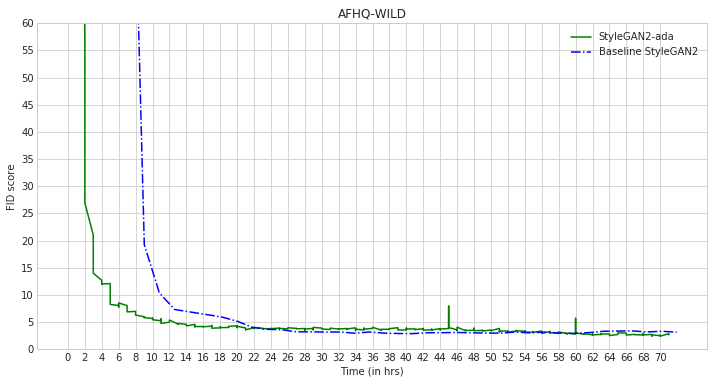

In [5]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()

ds1 = 'AFHQ-WILD'
ds2 = 'StyleGAN2_WILD-AFHQ'

ds1_t = [
    x for x in FID_history[ds1]['times'] if x <= max(FID_history[ds2]['times'])
]
ds1_t = [int(x) for x in ds1_t]

ds1_f = FID_history[ds1]['FID'][:len(ds1_t)]

ds2_t = FID_history[ds2]['times']
ds2_f = FID_history[ds2]['FID']

ax.plot(ds1_t, ds1_f, '-g', label='StyleGAN2-ada')
ax.plot(ds2_t, ds2_f, '-.b', label='Baseline StyleGAN2')

ax.set(xlabel='Time (in hrs)', ylabel='FID score', title=ds1)
plt.xticks(np.arange(0, max(ds1_t), 2))
plt.yticks(np.arange(0, max(ds1_f), 5))
plt.ylim(0, 60)
plt.legend()

## Compare different subsets of FFHQ by subset size (ADA)

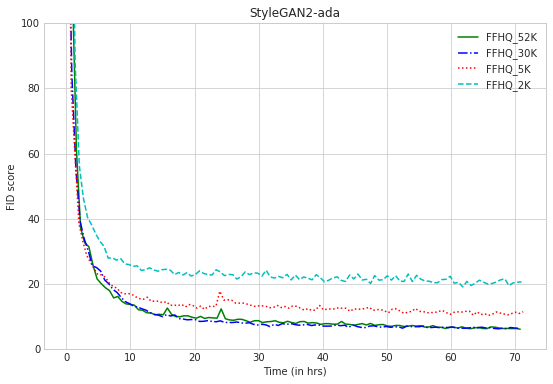

In [15]:
# FID scores for different subsets of FFHQ at 256×256 resolution
fig = plt.figure(figsize=(9, 6))
ax = plt.axes()

FFHQs = ['FFHQ_custom', 'FFHQ_custom_30K', 'FFHQ_custom_5K', 'FFHQ_custom_2K']

for x, style in zip(FFHQs, ['-g', '-.b', ':r', '--c']):
    ds_t = FID_history[x]['times']
    ds_f = FID_history[x]['FID']
    
    if x == 'FFHQ_custom':
        x = 'FFHQ_custom_52K'
    ax.plot(ds_t, ds_f, style, label=x.replace('_custom', ''))

    ax.set(xlabel='Time (in hrs)', ylabel='FID score',
           title='StyleGAN2-ada')

    plt.ylim(0, 100)
    plt.legend()

## Compare different subsets of FFHQ by subset size (Baseline StyleGAN2)

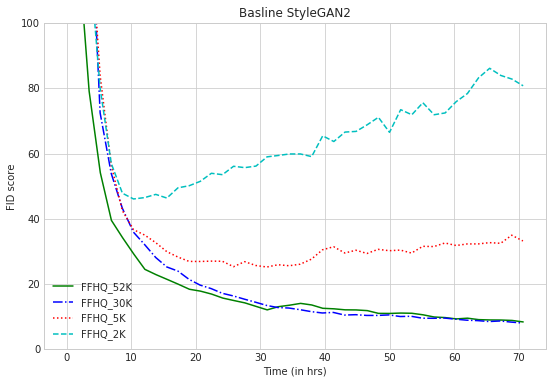

In [17]:
fig = plt.figure(figsize=(9, 6))
ax = plt.axes()

FFHQs = ['StyleGAN2_FFHQ_custom', 'StyleGAN2_FFHQ_custom_30K', 'StyleGAN2_FFHQ_custom_5K', 'StyleGAN2_FFHQ_custom_2K']

for x, style in zip(FFHQs, ['-g', '-.b', ':r', '--c']):
    ds_t = FID_history[x]['times']
    ds_f = FID_history[x]['FID']
    
    if x == 'StyleGAN2_FFHQ_custom':
        x = 'StyleGAN2_FFHQ_custom_52K'
    ax.plot(ds_t, ds_f, style, label=x.replace('_custom', '').replace('StyleGAN2_', ''))

    ax.set(xlabel='Time (in hrs)', ylabel='FID score',
           title='Basline StyleGAN2')

    plt.ylim(0, 100)
    plt.legend()

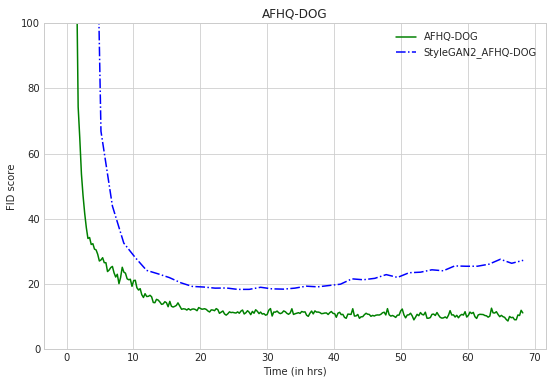

In [23]:
# FID scores for different subsets of FFHQ at 256×256 resolution
fig = plt.figure(figsize=(9, 6))
ax = plt.axes()

FFHQs = ['AFHQ-DOG', 'StyleGAN2_AFHQ-DOG']

for x, style in zip(FFHQs, ['-g', '-.b']):
    if x == 'AFHQ-DOG':
        ds_t = FID_history[x]['times']
        ds_f = FID_history[x]['FID']
    else:
        ds_t = [x for x in FID_history[x]['times']][:42]
        ds_f = FID_history[x]['FID'][:42]
    
    
    ax.plot(ds_t, ds_f, style, label=x)

    ax.set(xlabel='Time (in hrs)', ylabel='FID score',
           title='AFHQ-DOG')

    plt.ylim(0, 100)
    plt.legend()